In [1]:
# Use dflat_v2 conda environment
import matplotlib.pyplot as plt
import numpy as np
import torch
from dflat.initialize import focusing_lens
from dflat.metasurface import load_optical_model
from dflat.propagation.propagators_legacy import PointSpreadFunction  # Using the legacy version as it takes wavelength as a forward input instead of initialization input
from dflat.metasurface import datasets
import einops

In [2]:
def closest_index(value, array):
    """
    Find the index of the closest value in an array.

    Parameters:
        array (np.ndarray): The array to search.
        value (float): The value to find the closest match for.

    Returns:
        int: The index of the closest value in the array.
    """
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()

def reverse_lookup_search_Nanocylinders_TiO2_U300nm_H600nm(amp, phase, wavelength_set_m, *args, **kwargs):
    L, H, W = amp.shape[-3::]
    assert amp.shape == phase.shape
    assert (
        len(wavelength_set_m) == L
    ), "Wavelength list should match amp,phase wavelength dim (dim3)."
    assert (
        len(wavelength_set_m) == 1
    ), "only support a single wavelength."

    model = datasets.Nanocylinders_TiO2_U300nm_H600nm()
    idx = closest_index(wavelength_set_m[0], model.params[1])

    lib_amp = model.trans[:,idx]  # 121 elements
    lib_phase = model.phase[:,idx]
    lib = lib_amp * np.exp(1j * lib_phase)
    target = np.expand_dims(amp * np.exp(1j * phase), axis=-1)
    diff = np.abs(lib - target)  # (1, 1, 1, 1025, 1025, 121)
    selection_index = np.argmin(diff, axis=-1)
    # print(model.params[0].min(), model.params[0].max(),model.params[0])
    op_param = model.params[0][selection_index]
    op_param = einops.rearrange(op_param, 'b p 1 h w -> b h w p')
    op_param_norm = (op_param - model.param_limits[0][0])/(model.param_limits[0][1] - model.param_limits[0][0])
    err = []
    return op_param_norm, op_param, err

In [3]:
in_size=[1601, 1601]
in_dx_m=[2.5e-6, 2.5e-6]
wavelength_set_m=[532e-9]
out_dx_m=[2.74e-6, 2.74e-6] # Basler dart M dmA4096-9gm (Mono) pixel size multiply 3
# out_size=[375*8+1, 513*8+1]
out_size=[513*4+1, 513*4+1]

depth_set_m=[99999]
fshift_set_m=[[0.0, 0.0]]
out_distance_m=1e-2
aperture_radius_m=2e-3
radial_symmetry=False
second_metasurface_depth_m=1e-3

(1, 1601, 1601) (1, 1601, 1601) (1, 1601, 1601)


Text(0.5, 1.0, 'phase')

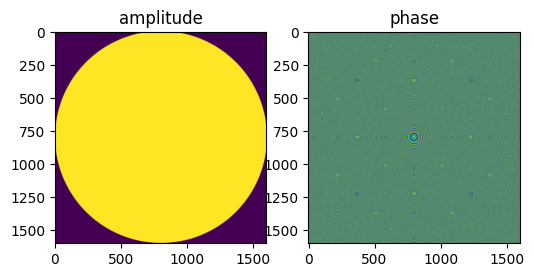

In [4]:
# define the lens
amp, phase, aperture = focusing_lens(
    in_size=in_size,
    in_dx_m=in_dx_m,
    wavelength_set_m=wavelength_set_m,
    depth_set_m=depth_set_m,
    fshift_set_m=fshift_set_m,
    out_distance_m=out_distance_m,
    aperture_radius_m=aperture_radius_m,
    radial_symmetry=radial_symmetry
)
# returns focusing profiles of shape [Z, Lam, H, W]
print(amp.shape, phase.shape, aperture.shape)

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(amp[0]*aperture[0], vmin=0, vmax=1)
ax[0].set_title("amplitude")
ax[1].imshow(phase[0])
ax[1].set_title("phase")

In [5]:
# Nearest neightbor lookup
amp_exp = np.expand_dims(np.expand_dims(amp, axis=0), axis=0)
phase_exp = np.expand_dims(np.expand_dims(phase, axis=0), axis=0)
aperture_exp  = np.expand_dims(np.expand_dims(aperture, axis=0), axis=0)
reverse_lookup_f = reverse_lookup_search_Nanocylinders_TiO2_U300nm_H600nm
p_norm, p, err = reverse_lookup_f(amp_exp, phase_exp, wavelength_set_m[0:1])

In [7]:
!nvidia-smi

Mon Apr 28 11:02:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A30                     On  |   00000000:21:00.0 Off |                    0 |
| N/A   28C    P0             31W /  165W |   23980MiB /  24576MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [9]:
print(p.shape)

(1, 1601, 1601, 1)


In [8]:
model_name = 'Nanocylinders_TiO2_U300H600'
optical_model = load_optical_model(model_name)#.cuda()
est_amp, est_phase = optical_model(torch.from_numpy(p).cuda(), wavelength_set_m, pre_normalized=False)

Target Module: dflat.metasurface.optical_model.NeuralCells
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


/tmp/ipykernel_1331799/2384999652.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(est_amp, dtype=torch.float32),
/tmp/ipykernel_1331799/2384999652.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(est_phase, dtype=torch.float32),


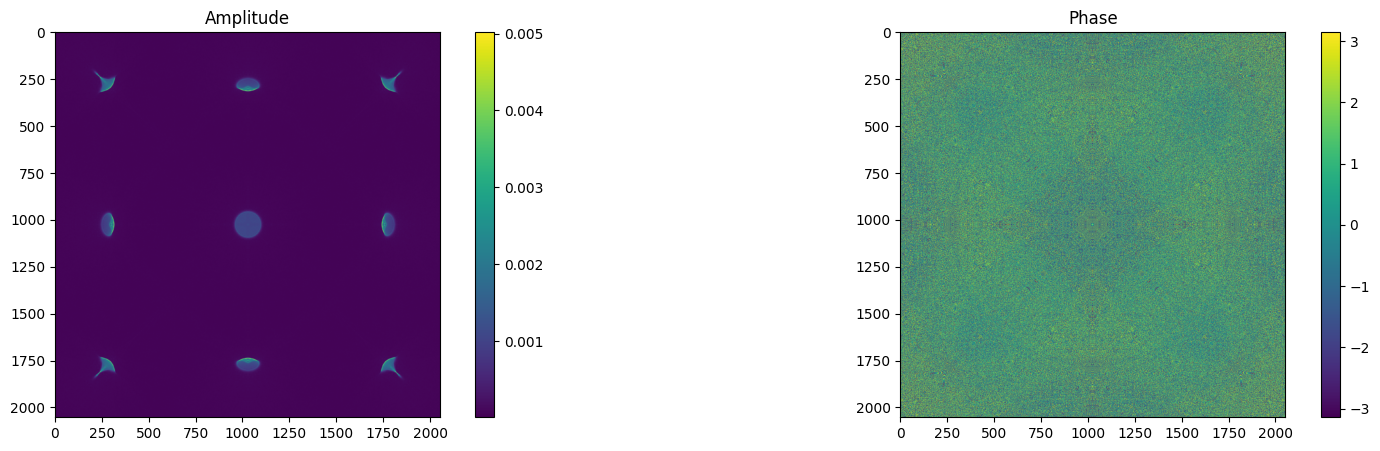

In [ ]:
# calculate the light field 1mm before the photosensor
# The ASM propagator naturally provides PSFs of a grid of incident angles due to the discrete sampling of the metasurface phase profile
PSF = PointSpreadFunction(
    in_size=in_size,
    in_dx_m=in_dx_m,
    out_distance_m=out_distance_m-second_metasurface_depth_m,
    out_size=out_size,
    out_dx_m=out_dx_m,
    out_resample_dx_m=None,
    radial_symmetry=radial_symmetry,
    diffraction_engine="ASM"
)

ps_locs = [[0, 0, 1e2]]
sim_wl = [532e-9]

intensity, phase = PSF(
    torch.tensor(est_amp, dtype=torch.float32),
    torch.tensor(est_phase, dtype=torch.float32),
    sim_wl,
    ps_locs,
    aperture=aperture_exp,
    normalize_to_aperture=True)
intensity = intensity.cpu().numpy()
amplitude = np.sqrt(intensity)
phase = phase.cpu().numpy()

fig = plt.figure(figsize=(20,5))
fig.add_subplot(1,2,1)
plt.imshow(amplitude[0,0, 0, 0,:,:])
plt.title("Amplitude")
plt.colorbar()

fig.add_subplot(1,2,2)
plt.imshow(phase[0,0, 0, 0,:,:])
plt.title("Phase")
plt.colorbar()
plt.show()

Number of clusters after filtering: 9


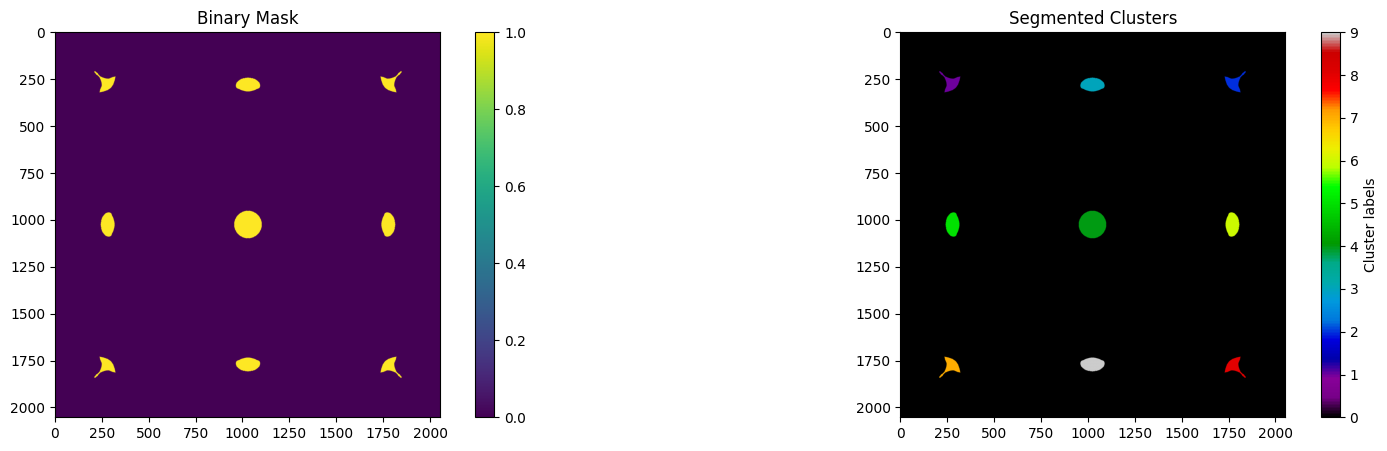

In [24]:
# segment each PSF and separately propagate for 1mm
# label each cluster in the binary image
from scipy.ndimage import label
# Label connected clusters (8-connectivity)

binary_image = amplitude[0,0, 0, 0,:,:]>0.0005
labeled_array, num_features = label(binary_image, structure=np.ones((3,3)))

# Threshold for minimum cluster size
threshold = 30

# Remove clusters smaller than threshold
filtered_labels = np.copy(labeled_array)
for label_idx in range(1, num_features + 1):
    cluster_size = np.sum(labeled_array == label_idx)
    if cluster_size < threshold:
        filtered_labels[filtered_labels == label_idx] = 0

# Re-label the remaining clusters
filtered_labels, new_num_features = label(filtered_labels > 0, structure=np.ones((3,3)))

print("Number of clusters after filtering:", new_num_features)

# Visualize the clusters
fig = plt.figure(figsize=(20,5))
fig.add_subplot(1,2,1)
plt.imshow(binary_image)
plt.title("Binary Mask")
plt.colorbar()
fig.add_subplot(1,2,2)
plt.imshow(filtered_labels, cmap='nipy_spectral')
plt.colorbar(label='Cluster labels')
plt.title('Segmented Clusters')
plt.show()

In [17]:
def find_bounding_box(binary_map):
    rows = np.any(binary_map, axis=1)
    cols = np.any(binary_map, axis=0)

    if not rows.any() or not cols.any():
        raise ValueError("The binary map contains no ones.")

    top, bottom = np.where(rows)[0][0], np.where(rows)[0][-1]
    left, right = np.where(cols)[0][0], np.where(cols)[0][-1]

    upper_left = (top, left)
    bottom_right = (bottom, right)

    return upper_left, bottom_right


In [18]:
# Propgating for 1mm from the second metasurface to the photosensor

# select the PSF, the central PSF
idx = 4
amp_2ndprop = np.squeeze(amplitude) * (filtered_labels == idx)
phase_numerical = np.squeeze(phase) * (filtered_labels == idx)
xx, yy = np.meshgrid(
    np.arange(amplitude.shape[-1])-amplitude.shape[-1]//2, np.arange(amplitude.shape[-2])-amplitude.shape[-2]//2, indexing="xy")
xx = xx * out_dx_m[0]
yy = yy * out_dx_m[1]
phase_analytical =  np.angle(np.exp(1j*-2*np.pi/sim_wl[0] * np.sqrt(xx**2 + yy**2 + second_metasurface_depth_m**2)))
amp_2ndprop = np.expand_dims(np.expand_dims(amp_2ndprop, axis=0), axis=0)
phase_2ndprop = np.expand_dims(np.expand_dims(phase_numerical, axis=0), axis=0)


PSF_2ndprop = PointSpreadFunction(
    in_size=out_size,
    in_dx_m=out_dx_m,
    out_distance_m=second_metasurface_depth_m,
    out_size=out_size,
    out_dx_m=out_dx_m,
    out_resample_dx_m=None,
    radial_symmetry=False,
    diffraction_engine="ASM")

intensity_sensor, _ = PSF_2ndprop(
    torch.tensor(amp_2ndprop, dtype=torch.float32),
    torch.tensor(phase_2ndprop, dtype=torch.float32),
    sim_wl,
    [[0,0,99999]],
    aperture=None,
    normalize_to_aperture=True)
intensity_sensor = intensity_sensor.cpu().numpy()

ul, br = find_bounding_box(amp_2ndprop.squeeze())
# ul = [0, 0]
# br = amp_2ndprop.shape[-2:]

fig = plt.figure(figsize=(10,10), dpi=200)
fig.add_subplot(2,2,1)
plt.imshow(np.squeeze(amp_2ndprop)[ul[0]:br[0],ul[1]:br[1]])
plt.colorbar()
plt.title("Amplitude at 1mm")
fig.add_subplot(2,2,2)
plt.imshow(np.squeeze(phase_numerical)[ul[0]:br[0],ul[1]:br[1]])
plt.colorbar()
plt.title("Numerical phase at 1mm")
fig.add_subplot(2,2,3)
plt.imshow(np.squeeze(phase_analytical)[ul[0]:br[0],ul[1]:br[1]])
plt.colorbar()
plt.title("Analytical phase at 1mm")
fig.add_subplot(2,2,4)
plt.imshow(np.squeeze(intensity_sensor)[ul[0]:br[0],ul[1]:br[1]])
plt.title("PSF at photosensor, notice it's incorrect")
plt.colorbar()
plt.show()

ValueError: The binary map contains no ones.